# Practical assignment 4
#### Group 8: Christopher Galias (s1009417) and Robin de Heer (s4349792)

### 1. Estimate	B on the training set. Normally, you should use	cross validation to estimate lambda. For simplicity, you can assume that $\lambda = 10^{-6}$. Reconstruct $x$ from $y$ in the test set. Visualize the original test stimuli and	their reconstructions.	

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from scipy.io import loadmat
from sklearn.linear_model import Ridge

Set the regularization hyperparameter.

In [2]:
l = pow(10, -6)

Read in data.

In [3]:
data = loadmat("69dataset.mat")

prior = data["prior"]
X = data["X"]
Y = data["Y"]

Show an example picture.

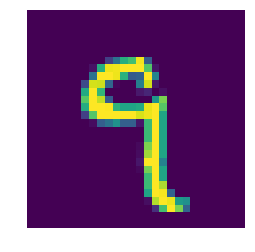

In [4]:
plt.axis('off')
_ = plt.imshow(X[np.random.randint(0, X.shape[0])].reshape(28, 28).T)

Define helper functions.

In [5]:
def std(X):
    std_X = X.std(axis=0, keepdims=True)
    std_X[std_X == 0] = 1
    return std_X

In [6]:
def normalize(X):
    return (X - X.mean(axis=0, keepdims=True)) / std(X)

Normalize the data.

In [7]:
X_norm = normalize(X)
Y_norm = normalize(Y)
prior_norm = normalize(prior)

Save the mean and standard deviation for plotting.

In [8]:
mean_X = X.mean(axis=0, keepdims=True)
std_X = std(X)

Create the train/test splits.

In [9]:
perm_1 = np.random.permutation(range(50))
perm_2 = np.random.permutation(range(50, 100))

ind_test_6 = perm_1[:10] 
ind_train_6 = perm_1[10:]
ind_test_9 = perm_2[:10]
ind_train_9 = perm_2[10:]

ind_test = np.concatenate((ind_test_6, ind_test_9), axis=0)
ind_train = np.concatenate((ind_train_6, ind_train_9), axis=0)

X_train, Y_train = X_norm[ind_train], Y_norm[ind_train]
X_test, Y_test = X_norm[ind_test], Y_norm[ind_test]

Define the ridge regression function.

In [10]:
def ridge_regression(X, Y, l):
    return np.dot(np.linalg.inv(np.dot(X.T, X) + 
                                l * np.identity(X.shape[1])), 
                  np.dot(X.T, Y))

Fit the data using ridge regression, first using our solution and then sklearn's (to verify).

In [11]:
B = ridge_regression(Y_train, X_train, l)

clf = Ridge(alpha=l, fit_intercept=False)
_ = clf.fit(Y_train, X_train)

Calculate the predictions on the test set.

In [12]:
X_pred_sklearn = clf.predict(Y_test)

X_pred_manual = np.dot(Y_test, B)

Define a helper plot function.

In [13]:
def plot_examples(X, Y, Z, mean, std_, titles):

    assert X.shape == Y.shape and Y.shape == Z.shape
    assert len(titles) == 3
    
    n = X.shape[0]
    
    # "unnormalize" the data 
    X = X * std_ + mean
    Y = Y / std(Y) * std_ - Y.mean(axis=0, keepdims=True) + mean
    Z = Z / std(Z) * std_ - Z.mean(axis=0, keepdims=True) + mean
    
    fig = plt.subplots(n, 3, sharex=True, sharey=True, figsize=(7, 7/3 * n))
    for i in range(n):

        plt.subplot(n, 3, i*3+1, xticks=[], yticks=[])
        plt.imshow(X[i].reshape(28, 28).T)
        plt.ylabel('test image no. ' + str(i+1))
        if i == 0:
            plt.title(titles[0])
        
        plt.subplot(n, 3, i*3+2, xticks=[], yticks=[])
        plt.imshow(Y[i].reshape(28, 28).T)
        if i == 0:
            plt.title(titles[1])

        plt.subplot(n, 3, i*3+3, xticks=[], yticks=[])
        plt.imshow(Z[i].reshape(28, 28).T)
        if i == 0:
            plt.title(titles[2])

Plot the original test stimuli and their reconstructions.

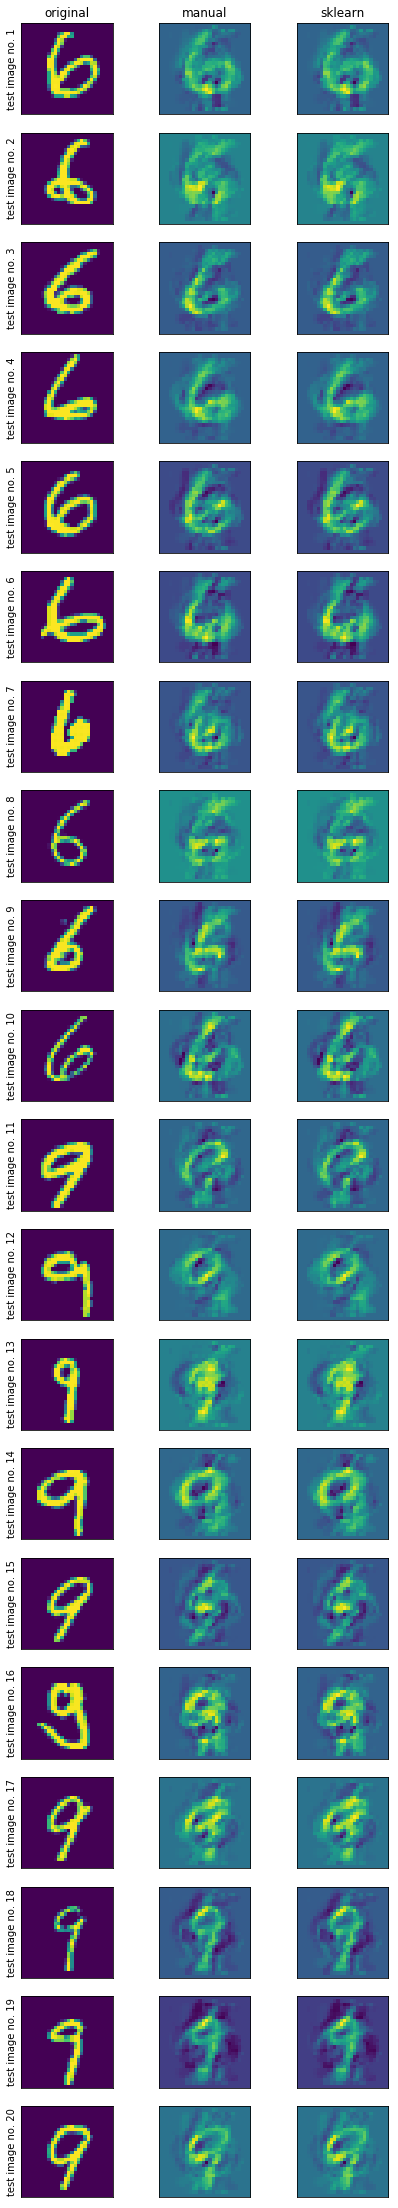

In [14]:
plot_examples(X_test, X_pred_manual, X_pred_sklearn, mean_X, std_X, ["original", "manual", "sklearn"])

The predicted images look the same, so it appears we've implemented ridge regression correctly.

In [15]:
X_pred = X_pred_manual

To avoid confusion, we will refer to the output of the second ridge regression calculation as $A$ instead of $B$.

### 2. Estimate $A$ on the training set. Normally, you should use cross-validation to estimate $\lambda$ and $\Sigma$. For simplicity, you can assume that $\lambda = 10^{-6}$ and $\Sigma = 10^{-3} I$. Estimate $\Sigma_{prior}$. Tip: add $10^{-6}$ to the diagonal of $\Sigma_{prior}$ for regularization. Visualize $\Sigma_{prior}$ using the imshow function. Can you explain what it shows?

Fit the data using ridge regression.

In [16]:
A = ridge_regression(X_train, Y_train, l)

Assume $\Sigma$ as in the assignment instructions.

In [17]:
s = pow(10, -3)
sigma = s * np.identity(Y_train.shape[1])

Estimate $\Sigma_{prior}$ and add the regularization term to it.

In [18]:
sigma_prior = np.dot(prior_norm.T, prior_norm) / (prior_norm.shape[0] - 1) + l * np.identity(prior_norm.shape[1])

Visualize $\Sigma_{prior}$.

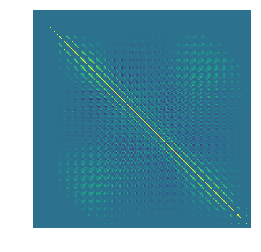

In [19]:
plt.axis('off')
_ = plt.imshow(sigma_prior.T)

Pixels are correlated with their neighbors, which is represented by a slightly fat diagonal.

We can also visualize the covariances for individual pixels.

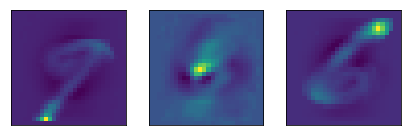

In [20]:
fig = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(7, 2.5))
plt.subplot(1, 3, 1, xticks=[], yticks=[])
plt.imshow(sigma_prior[250].reshape(28, 28).T)

plt.subplot(1, 3, 2, xticks=[], yticks=[])
plt.imshow(sigma_prior[350].reshape(28, 28).T)

plt.subplot(1, 3, 3, xticks=[], yticks=[])
_ = plt.imshow(sigma_prior[620].reshape(28, 28).T)

We can see that pixels are strongly correlated with their local neighbourhood, but some are also correlated with a subset which resembles a $6$ or a $9$. This just means that the particular pixel is most likely to be part of that number (e.g., in the first case, it's hard to draw a $6$ which goes all the way down-left). We can also see that covariances of pixels in the middle are more of a mishmash, as these pixels can be part of different digits.

### 3. Reconstruct $x$ from $y$ in the test set using the generative approach. Visualize the reconstructions. Compare the reconstructions with the earlier reconstructions. Which one is better? Why? Can you think of ways to improve the results using neural networks?

Calculate the reconstructions.

In [21]:
sigma_inv = np.linalg.inv(sigma)

L = np.linalg.inv(np.linalg.inv(sigma_prior) + np.dot(np.dot(A, sigma_inv), A.T))
R = np.dot(A, sigma)

mu_post = np.dot(np.dot(L, R), Y_test.T).T

Visualize the reconstructions.

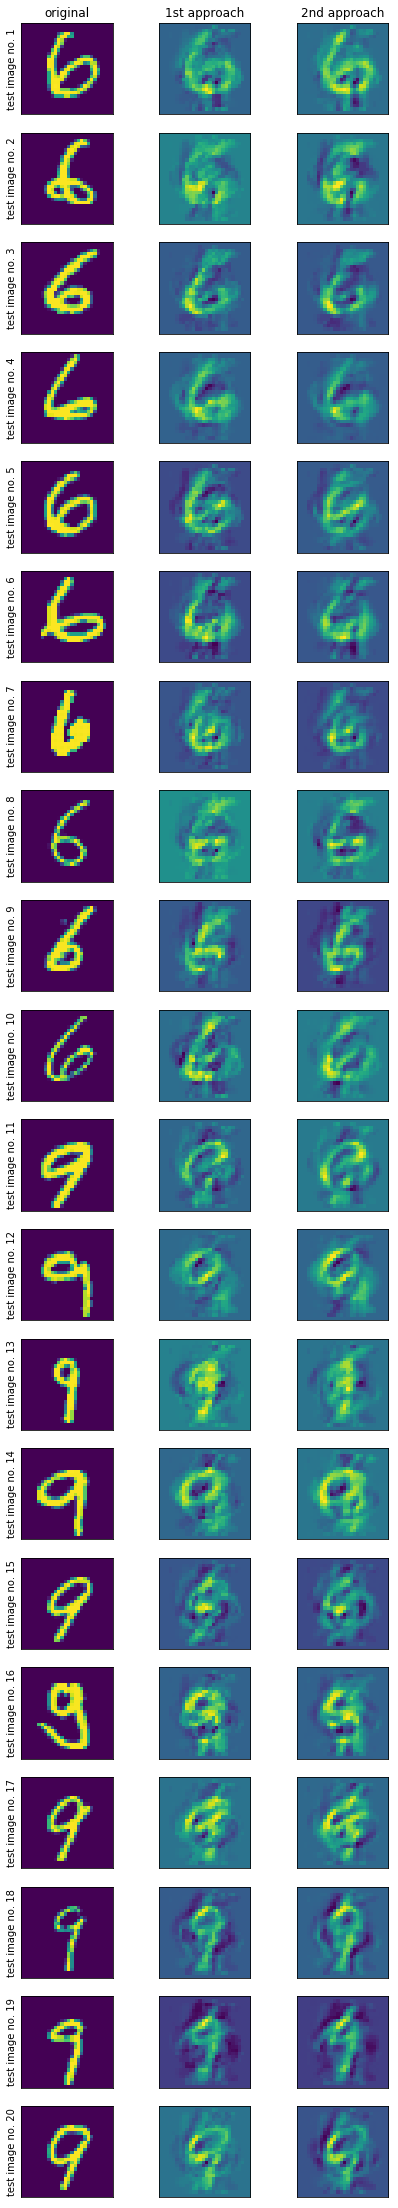

In [22]:
plot_examples(X_test, X_pred, mu_post, mean_X, std_X, titles=["original", "1st approach", "2nd approach"])

The second approach appears to be better. This is most likely because we're also using the information of the prior, wheares the first approach uses just the likelihood (though in our specific case, the prior just adds some gaussian smoothing).

Linear regression can be seen as a very simple one-layer neural network. To seek improvements, we could add more layers to enable learning more complicated image features. Furthermore, we could use convolutional neural networks, as their inductive bias is well-suited to images.